# Learning to Reweight Examples for Robust Deep Learning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ML_Project

/content/drive/.shortcut-targets-by-id/1WNR3o2CO38kvudaWBLsGkvJvMa4hkl39/ML_Project


In [3]:
%cd /content/drive/MyDrive/ML_Project/learning-to-reweight-examples/

/content/drive/.shortcut-targets-by-id/1WNR3o2CO38kvudaWBLsGkvJvMa4hkl39/ML_Project/learning-to-reweight-examples


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from model import *
from data_loader import *
from wide_resnet import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import gc
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 5})
import numpy as np
import random
import os
import csv

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
hyperparameters = {
    'lr' : 0.1,
    'momentum' : 0.9,
    'batch_size' : 25,
    'num_iterations' : 100,
}

In [6]:
data_loader = get_cifar_loader(hyperparameters['batch_size'], cifar_type="10", mode="train", run_type="bkgnd_flip")
test_loader = get_cifar_loader(hyperparameters['batch_size'], cifar_type="10", mode="test",run_type="bkgnd_flip")

Files already downloaded and verified
50000
bkgnd_flip
torch.Size([1000, 3, 32, 32])
torch.Size([1000])


/content/drive/.shortcut-targets-by-id/1WNR3o2CO38kvudaWBLsGkvJvMa4hkl39/ML_Project/learning-to-reweight-examples/data_loader.py:176: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  self.data = torch.tensor(self.data).squeeze(0)


Files already downloaded and verified


In [7]:
def to_var(x, requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad)

In [8]:
def build_model_wrn(cifar_type, model_type):
    net = Wide_ResNet(28, 10, 0.3, cifar_type)
    if(model_type == "baseline"):
      if os.path.isfile("cifar_bkgnd_baseline.pt"):
        net.load_state_dict(torch.load('cifar_bkgnd_baseline.pt'))
    elif(model_type == "reweight"):
      if os.path.isfile("cifar_bkgnd_reweight.pt"):
        net.load_state_dict(torch.load('cifar_bkgnd_reweight.pt'))
    if torch.cuda.is_available():
        net.cuda()
        torch.backends.cudnn.benchmark=True

    opt = torch.optim.SGD(net.params(),lr=hyperparameters["lr"])
    
    return net, opt

In [9]:
val_data = data_loader.dataset.data_val
val_labels = data_loader.dataset.labels_val

#val_data = val_data[:100]
#val_labels = val_labels[:100]

In [10]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

val_dataset = CIFAR_VAL(val_data, val_labels)
val_data_loader = DataLoader(dataset=val_dataset,
                             batch_size=25,
                             shuffle=True, num_workers=2)
    

In [11]:
iter_start = 0
iter_end = 0

In [36]:
from wide_resnet import Wide_ResNet

def train_lre_cifar_baseline():
    net_baseline, opt_baseline = build_model_wrn(cifar_type=10,model_type="baseline")

    global val_data
    global val_labels
    net_losses_baseline = []
    plot_step = 100
    smoothing_alpha = 0.9
    lr_update = 1
    accuracy_log_baseline = []

    csv_net_losses_baseline = []
    csv_acc_baseline = []
    if os.path.isfile("acc_log_baseline_cifar_bkgnd_flip.csv"):
      with open("acc_log_baseline_cifar_bkgnd_flip.csv", "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
          csv_acc_baseline.append(list(np.float_(row)))
      csv_file.close()
      with open("loss_log_baseline_cifar_bkgnd_flip.csv", "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
          csv_net_losses_baseline.append(list(np.float_(row)))
      csv_file.close()

    csv_net_losses_baseline = np.array(csv_net_losses_baseline)
    csv_acc_baseline = np.array(csv_acc_baseline)

    for i in tqdm(range(iter_start,iter_end)):
        if i > 40000:
          lr_update = 0.1
        if i > 60000:
          lr_update = 0.01
        opt_baseline.param_groups[0]['lr'] = lr_update * hyperparameters['lr']
        net_baseline.train()
        # Line 2 get batch of data
        image, labels = next(iter(data_loader))
        image = to_var(image, requires_grad=False)
        labels = to_var(labels.type(torch.LongTensor), requires_grad=False)   
        y_baseline = net_baseline(image)
        cost_baseline = F.cross_entropy(y_baseline, labels)

        opt_baseline.zero_grad()
        cost_baseline.backward()
        opt_baseline.step()

        net_losses_baseline.append(cost_baseline.item())

        if i % plot_step == 0:
            net_baseline.eval()
            acc_baseline = []
            for itr,(test_img, test_label) in enumerate(test_loader):
                test_img = to_var(test_img, requires_grad=False)
                test_label = to_var(test_label, requires_grad=False)

                output_baseline = net_baseline(test_img)
                output_baseline = F.softmax(output_baseline, dim = 1)
                predicted_baseline = torch.argmax(output_baseline, dim = 1).int()
                acc_baseline.append((predicted_baseline.int() == test_label.int()).float())
            accuracy_baseline = torch.cat(acc_baseline,dim=0).mean()
            accuracy_log_baseline.append(np.array([i,accuracy_baseline.cpu()])[None])
            
            IPython.display.clear_output()
            fig, axes = plt.subplots(1, 2, figsize=(13,5))
            ax1, ax2 = axes.ravel()

            net_losses_baseline_plot = np.concatenate((csv_net_losses_baseline.flatten(),np.array(net_losses_baseline)), axis=0) if csv_net_losses_baseline.size else np.array(net_losses_baseline)
            ax1.plot(net_losses_baseline_plot, label='net_losses_baseline')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            acc_log_baseline = np.concatenate((csv_acc_baseline, np.concatenate(accuracy_log_baseline,axis=0)), axis=0) if csv_acc_baseline.size else np.concatenate(accuracy_log_baseline,axis=0)
            ax2.plot(acc_log_baseline[:,0],100*acc_log_baseline[:,1],label='accuracy_baseline')
            ax2.legend()
            ax2.set_ylabel('Accuracy %')
            ax2.set_xlabel('Iteration')
            plt.show()
            
    torch.save(net_baseline.state_dict(), 'cifar_bkgnd_baseline.pt')
        # return accuracy
    return np.concatenate(accuracy_log_baseline,axis=0), np.array(net_losses_baseline) 

In [37]:
iter_start = 80000
iter_end = 80100

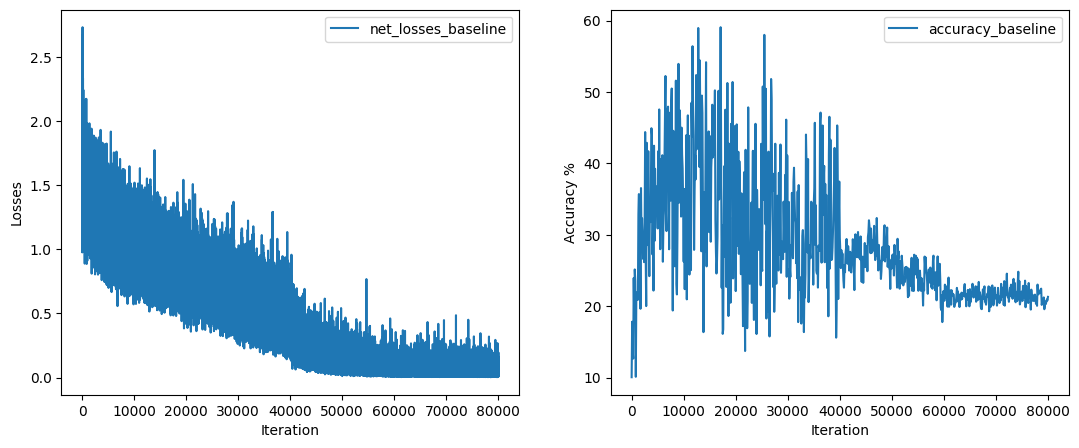

100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


In [38]:
acc_log_baseline, net_losses_baseline = train_lre_cifar_baseline()
with open('acc_log_baseline_cifar_bkgnd_flip.csv','a') as csvfile:
  np.savetxt(csvfile, acc_log_baseline, delimiter=',',fmt='%s', comments='')
  csvfile.close()
with open('loss_log_baseline_cifar_bkgnd_flip.csv','a') as csvfile:
  np.savetxt(csvfile, net_losses_baseline, delimiter=',',fmt='%s', comments='')
  csvfile.close()